In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn import svm
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from DLtools.Data import instant_data,intersection,del_less_col,station_sel
from DLtools.evaluation_rec import real_eva_error
from DLtools.feature_sel import call_mar


# Load data

In [2]:
loading = instant_data()
# df,mode = loading.hourly_instant(),'hour'
df,mode = loading.daily_instant(),'day'

if mode =='hour': n_past,n_future = 24*7,24
elif mode =='day': n_past,n_future = 30,14
else: n_future=None; print('incorrect input')

st = 'CPY012'
target,start_p,stop_p,host_path=station_sel(st,mode)
save_path =host_path+'/SVR/'

# Handle missing data, clean data


Before del col are... 305
After... 219


<AxesSubplot:xlabel='date'>

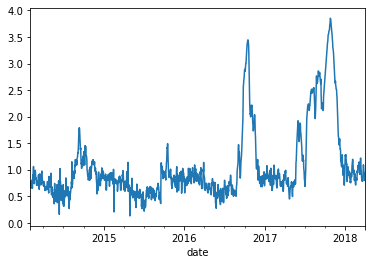

In [3]:
data = df[start_p:stop_p]
data = del_less_col(data,ratio=.85).interpolate(limit=3000000000,limit_direction='both').astype('float32')
data['Day'] = data.index.dayofyear #add day
data[target].plot()

# Shift target date

In [4]:
data[target]=data[target].shift(-n_past)
data = data.shift(-n_past)
data = data.dropna(axis='index')

# MAR feature selection

In [5]:
data_mar = call_mar(data,target,mode)
data_mar.head()

,CHM006_wl,DNP006_press,DNP011_press,Dam_SK_Useable_WaterVol,DNP032_press,NAN009_wl,Dam_BH_Useable_WaterVol,Dam_SK_WaterVol,DNP017_press,YOM007_wl,WAN002_wl,YOM008_wl,CHM002_wl,PIN003_rain,DNP019_press,CHM005_wl,DNP032_rain,PAS005_wl,CPY012_wl
date,,,,,,,,,,,,,,,,,,,
2014-02-01,269.527618,975.872192,950.455444,1951.0,1004.032471,179.206787,2305.0,4801.0,954.795410,36.136196,146.532852,33.089169,291.817444,0.0,997.477295,329.826660,0.0,39.424515,0.698406
2014-02-02,269.545746,977.570007,951.722107,1933.0,1005.343750,179.206787,2284.0,4783.0,956.044067,36.114861,146.495972,33.089169,291.807220,0.0,998.697937,329.825623,0.0,39.381527,0.758056
2014-02-03,269.554840,977.109070,951.592834,1918.0,1005.723022,179.206787,2263.0,4768.0,955.440857,36.092087,146.458420,33.089169,291.834595,0.0,998.716675,329.827759,0.0,39.344048,0.780417
2014-02-04,269.517242,976.191406,950.455688,1901.0,1004.629089,179.206787,2252.0,4751.0,954.910889,36.068371,146.388840,33.089169,291.819916,0.0,997.476990,329.826660,0.0,39.309380,0.681806
2014-02-05,269.491669,976.767822,951.315002,1887.0,1005.705017,179.223007,2238.0,4737.0,955.474609,36.053944,146.387848,33.089169,291.850494,0.0,998.652100,329.831390,0.0,39.260929,0.722986


# Feature selection

In [6]:
def high_corr(data,threshold=.95):
    """Eliminate first columns with high corr"""
    corr_matrix = data.corr().abs()
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    # Find index of feature columns with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return to_drop
def corr_w_Y(data,target,threshold= 0.8):
    # correlation 
    corr_test = data.corr(method='pearson')[target]
    corr_test = corr_test[(corr_test> threshold) | (corr_test< -threshold) ]
    corr_test = corr_test.sort_values(ascending=False)
    #corr_test =corr_test[1:] # eliminate Target it own
    return corr_test

In [7]:
def corr_select(data,target):
    col_feature = corr_w_Y(data,target,0.5).index
    data = data[col_feature]
    
    high_col = high_corr(data.iloc[:,1:]) #exclude target it own
    data.drop(columns=high_col,inplace=True)
    return data

def plot_corr(data,syn):
    global n_past
    ##Display / save
    corr = data.corr()
    plt.subplots(figsize=(10,10))
    mask = np.triu(data.corr())
    sns.heatmap(data.corr(), annot = True, vmin=-1, vmax=1, center= 0,mask=mask)
    plt.savefig(save_path+'Corr_{}lag{}h.png'.format(syn,n_past), bbox_inches='tight')
    return

# SVR

In [8]:
from sklearn.preprocessing import StandardScaler

X = data_mar.drop(columns=[target]).values
Y = data_mar[target].values

sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(X)
Y = sc_y.fit_transform(Y.reshape(-1,1))

trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.3, shuffle=False)

In [9]:
model_rbf =svm.SVR(kernel='rbf').fit(trainX,trainY)
yhat_rbg = model_rbf.predict(testX)

model_li =svm.SVR(kernel='linear').fit(trainX,trainY)
yhat_li = model_li.predict(testX)

In [10]:
def Yhat_series(yhat):
    return yhat #pd.Series(yhat,index=test.index)

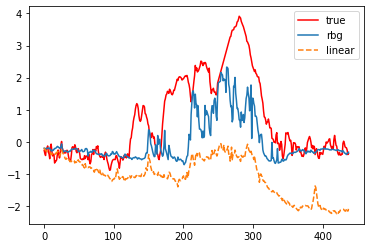

In [11]:
plt.plot(testY,'r',label="true")
plt.plot(Yhat_series(yhat_rbg),label="rbg")
plt.plot(Yhat_series(yhat_li),'--',label='linear')
plt.legend()
plt.show()

In [12]:
# with statsmodels
#X = sm.add_constant(trainX) # adding a constant
 
#model = sm.OLS(trainY, trainX).fit()
#predictions = model.predict(trainX) 
#model.summary()

In [13]:
kernals = ['Polynomial', 'RBF','Linear']#A function which returns the corresponding SVC model
def getClassifier(ktype):
    if ktype == 0:
        # Polynomial kernal
        return svm.SVR(kernel='poly', degree=8, gamma="auto")
    elif ktype == 1:
        # Radial Basis Function kernal
        return svm.SVR(kernel='rbf', gamma="auto")
    elif ktype == 2:
        # Linear kernal
        return svm.SVR(kernel='linear', gamma="auto")

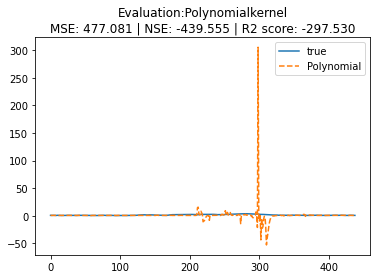

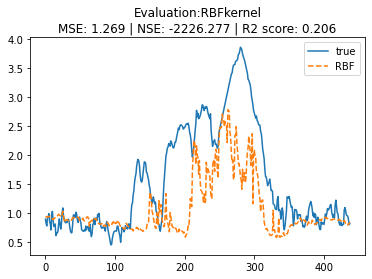

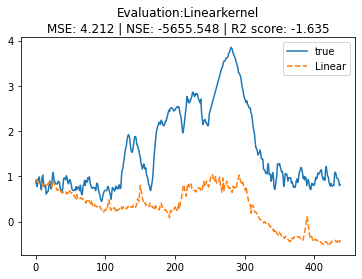

In [26]:
X = data_mar.drop(columns=[target]).values
Y = data_mar[target].values

sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(X)
Y = sc_y.fit_transform(Y.reshape(-1,1))

for i in range(3):
    # Separate data into test and training sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3,shuffle=False)# Train a SVC model using different kernal
    svclassifier = getClassifier(i) 
    svclassifier.fit(X_train, y_train)# Make prediction
    y_pred = svclassifier.predict(X_test)# Evaluate our model
    mse,nse,r2 = real_eva_error(y_test,y_pred)
    
    
    plt.title("Evaluation:"+kernals[i]+ "kernel"+ '\nMSE: %.3f | NSE: %.3f | R2 score: %.3f' % (mse,nse,r2))
    plt.plot(sc_y.inverse_transform(y_test),label="true")
    plt.plot(sc_y.inverse_transform(y_pred),'--',label=kernals[i])
    plt.legend()
    plt.show()

# Tuing hyperparameter


In [27]:
from sklearn.model_selection import GridSearchCV

In [41]:
param_grid = {'C': [1e-6,1e-5,1e-4,1e-3,1e-2,0.1,1,10,10**2,10**3,10**4,10**5,10**6], 'gamma': [1e-6,1e-5,1e-4,1e-3,1e-2,0.1,1,10,10**2,10**3,10**4,10**5,10**6],'kernel': ['rbf', 'linear']}
grid = GridSearchCV(svm.SVR(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)

C=0.0001, gamma=0.1, kernel=linear, total=   0.0s
[CV] C=0.001, gamma=1, kernel=rbf ....................................
[CV] ..................... C=0.001, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.001, gamma=1, kernel=rbf ....................................
[CV] ..................... C=0.001, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.001, gamma=1, kernel=rbf ....................................
[CV] ..................... C=0.001, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.001, gamma=1, kernel=rbf ....................................
[CV] ..................... C=0.001, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.001, gamma=1, kernel=rbf ....................................
[CV] ..................... C=0.001, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.001, gamma=1, kernel=linear .................................
[CV] .................. C=0.001, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.001, gamma=1, kernel=linear .................................
[CV] .................. C=0

GridSearchCV(estimator=SVR(),
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                               1000],
                         'gamma': [1, 0.1], 'kernel': ['rbf', 'linear']},
             verbose=2)

In [42]:
print(grid.best_estimator_)

SVR(C=0.1, gamma=0.1)


In [43]:
grid_predictions = grid.predict(X_test)


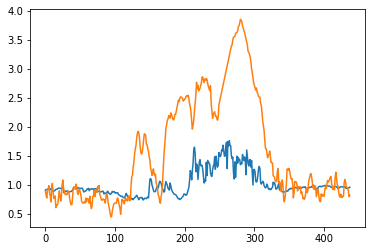

In [44]:
plt.plot(sc_y.inverse_transform(grid_predictions))
plt.plot(sc_y.inverse_transform(testY))

# Evaluation

In [ ]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [ ]:
record_result(trainY,testY,trainPredict,testPredict,'SVR_trial')

Plot

In [18]:
# plt.figure(figsize=(20,5))
# plt.plot(trainY.sort_index(),'.',label="Train_Actual")
# plt.plot(trainPredict.sort_index(),'.',label="Train_Predict")
# plt.plot(testY.sort_index(),'x',label="Test_Actual")
# plt.plot(testPredict.sort_index(),'x',label="Test_Predict")
# plt.title('[Multi Linear Regression *Testonly]\nWater Level CPY015 Forecast vs Actuals\n'+'Train MSE: %.3f | NSE: %.3f | R2 score: %.3f' % (mse,nse,r2)+'\nTest  MSE: %.3f | NSE: %.3f | R2 score: %.3f' % (Tmse,Tnse,Tr2))

# plt.legend()
# plt.show()
# #plt.savefig('output/Linear/result_Linear.png', dpi=300, bbox_inches='tight')

# VAR model

In [21]:
# VAR example
from statsmodels.tsa.vector_ar.var_model import VAR

https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

In [26]:
# from statsmodels.tsa.stattools import grangercausalitytests
# maxlag=12
# test = 'ssr_chi2test'
# def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
#     """Check Granger Causality of all possible combinations of the Time series.
#     The rows are the response variable, columns are predictors. The values in the table 
#     are the P-Values. P-Values lesser than the significance level (0.05), implies 
#     the Null Hypothesis that the coefficients of the corresponding past values is 
#     zero, that is, the X does not cause Y can be rejected.

#     data      : pandas dataframe containing the time series variables
#     variables : list containing names of the time series variables.
#     """
#     df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
#     for c in df.columns:
#         for r in df.index:
#             test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
#             p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
#             if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
#             min_p_value = np.min(p_values)
#             df.loc[r, c] = min_p_value
#     df.columns = [var + '_x' for var in variables]
#     df.index = [var + '_y' for var in variables]
#     return df

# grangers_causation_matrix(data, variables = data.columns)        

In [22]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(data)

/home/song/anaconda3/envs/tf/lib/python3.8/site-packages/statsmodels/tsa/vector_ar/vecm.py:569: HypothesisTestWarning: Critical values are only available for time series with 12 variables at most.
  warnings.warn("Critical values are only available for time series "
Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
DNP028_press ::  92610.75  > nan       =>   False
GLF001_wl ::  81100.49  > nan       =>   False
DNP006_humid ::  73269.35  > nan       =>   False
DNP002_temp ::  67007.75  > nan       =>   False
DNP032_temp ::  60871.01  > nan       =>   False
DNP002_humid ::  54857.68  > nan       =>   False
DNP007_temp ::  49216.66  > nan       =>   False
DNP008_temp ::  44046.14  > nan       =>   False
CPY015_rain1h ::  38901.69  > nan       =>   False
DNP033_rain1h ::  33999.06  > nan       =>   False
PAS005_wl ::  29306.31  > nan       =>   False
DNP010_humid ::  24901.66  > nan       =>   False
CPY009_temp ::  20891.21  > nan       =>   False
YOM

In [23]:
nobs = 4
train, test = data[0:-nobs], data[-nobs:]

In [24]:
model = VAR(train)
model_fit = model.fit()

In [25]:
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,41.94,41.95,1.644e+18,41.95
1,-8.753,-8.591,0.0001581,-8.702
2,-12.78,-12.46,2.825e-06,-12.68
3,-13.19,-12.71,1.875e-06,-13.04
4,-13.37,-12.74,1.557e-06,-13.17
5,-13.56,-12.77,1.291e-06,-13.31
6,-13.80,-12.85*,1.020e-06,-13.50
7,-13.95,-12.85,8.772e-07,-13.60
8,-14.09,-12.84,7.603e-07,-13.69
9,-14.24,-12.83,6.568e-07,-13.79


In [26]:
model_fitted = model.fit(4)
model_fitted.summary()

7.360           0.000
L1.DNP032_temp           0.000418         0.000510            0.819           0.413
L1.DNP002_humid         -0.000231         0.000126           -1.835           0.067
L1.DNP007_temp          -0.002361         0.000467           -5.054           0.000
L1.DNP008_temp          -0.001957         0.000540           -3.623           0.000
L1.CPY015_rain1h         0.000541         0.000511            1.060           0.289
L1.DNP033_rain1h         0.001741         0.000556            3.133           0.002
L1.PAS005_wl            -0.002977         0.001878           -1.585           0.113
L1.DNP010_humid         -0.000112         0.000100           -1.127           0.260
L1.CPY009_temp           0.000824         0.000220            3.742           0.000
L1.YOM009_wl             0.000124         0.003601            0.035           0.972
L1.DNP027_temp          -0.000465         0.000270           -1.724           0.085
L1.CPY013_wl             0.045144         0.005018    

In [27]:
lag_order = model_fitted.k_ar   
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = test.values[-lag_order:]
forecast_input

4


array([[ 9.35630000e+02,  1.56000000e+00,  8.98300000e+01,
         2.20500000e+01,  2.15600000e+01,  6.51700000e+01,
         2.30300000e+01,  1.91100000e+01,  0.00000000e+00,
         0.00000000e+00,  4.22200000e+01,  8.71700000e+01,
         3.18500000e+01,  2.68833333e+01,  2.20500000e+01,
         9.80000000e-01,  1.97355000e+02,  0.00000000e+00,
         1.81300000e+01,  7.53646592e+01,  7.75000000e+01,
         4.13300000e+01,  2.64600000e+01,  1.19166667e+02,
         1.40308622e+02,  1.96000000e+01,  1.20166667e+00,
        -3.83333333e-02],
       [ 9.36710000e+02,  1.26833333e+00,  9.48300000e+01,
         2.15600000e+01,  2.05800000e+01,  6.36700000e+01,
         2.20500000e+01,  1.86200000e+01,  0.00000000e+00,
         0.00000000e+00,  4.22200000e+01,  9.11700000e+01,
         3.28300000e+01,  2.68900000e+01,  2.15600000e+01,
         9.98333333e-01,  1.97360000e+02,  0.00000000e+00,
         1.76400000e+01,  7.53646592e+01,  8.15000000e+01,
         4.13300000e+01,  2.40

In [28]:
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=data.index[-nobs:], columns=data.columns + '_2d')
df_forecast

,DNP028_press_2d,GLF001_wl_2d,DNP006_humid_2d,DNP002_temp_2d,DNP032_temp_2d,DNP002_humid_2d,DNP007_temp_2d,DNP008_temp_2d,CPY015_rain1h_2d,DNP033_rain1h_2d,...,DNP033_temp_2d,DNP004_humid_2d,DNP007_humid_2d,NAN013_wl_2d,DNP025_temp_2d,PIN001_wl_2d,PAS001_wl_2d,DNP006_temp_2d,CPY012_wl_2d,CPY015_wl_2d
date,,,,,,,,,,,,,,,,,,,,,
2017-12-24 20:00:00,937.139697,0.300645,77.782017,19.068220,18.891805,72.040407,19.944447,16.859891,0.037525,-0.072343,...,17.282835,77.222369,88.206055,41.345033,21.755237,119.702681,140.297733,17.042952,1.293316,-0.351309
2017-12-24 21:00:00,936.980625,0.161930,78.426435,19.019191,18.692422,72.930838,19.449394,16.815759,-0.025087,-0.088847,...,17.542529,77.902245,89.115523,41.352572,21.029310,119.716061,140.293180,16.655664,1.234357,-0.107219
2017-12-24 22:00:00,936.610898,0.164726,77.649327,19.392180,18.891676,73.027530,19.086428,17.149344,-0.055256,-0.045454,...,18.104482,77.974661,89.313011,41.365973,20.860856,119.684872,140.283993,16.604989,1.158262,0.194701
2017-12-24 23:00:00,936.475450,0.298226,76.953467,20.058622,19.609979,72.049985,19.289789,17.698210,-0.070798,-0.041615,...,18.737152,77.712905,88.410086,41.370315,21.155439,119.624950,140.272485,17.025242,1.073779,0.499808
